# Constants And Penalties

In [1]:
import random
import numpy as np
import sys

import pandas as pd
import os
import matplotlib.pyplot as plt



import matplotlib.patches as patches

# ConStants
NUM_SEMESTERS = 8
NUM_SECTIONS = 2
NUM_THEORY_COURSES = 4 
NUM_LAB_COURSES = 2
NUM_PROFESSORS = 60
NUM_DAYS = 5

NUM_TIME_SLOTS = 5
MAX_ITERATIONS = 100

NUM_RESOURCES = 32 
CLASSROOM_CAPACITY = 60
LARGE_HALL_CAPACITY = 120
CHROMOSOME_LENGTH = NUM_SEMESTERS * NUM_SECTIONS * (NUM_THEORY_COURSES + NUM_LAB_COURSES) * 12

# Day names
DAY_NAMES = ["Monday",   "Tuesday", "Wednesday","Thursday",   "Friday"]

# Floor in Blocks
BLOCK_FLOORS = {
    'A': 3,  # number of floors in block A 5 Rooms Each
    'B': 3,  # number of floors in block B 5 Rooms Each
    
    'C': 5   # number of floors in block C 5 Rooms Each


}

# floor room Capacity 
roomsPerFloor = NUM_RESOURCES // sum(BLOCK_FLOORS.values())

#  time slots
TIME_SLOTS = [
    (8, 30, 9, 50),
    (10, 5, 11, 25),
    (11, 40, 13, 0),
     (13, 15, 14, 35),
    (15, 50, 17, 10)

]

#hard and soft comnstraints 
roomWieghtCapacity = 100  # penalty for room capAcity to make it a hard constraint

roomAvalabilityWight = 100  # penalty for room availability
proffessorAvaillabilityWeieght = 100  # penalty for professor availabiliTY
sectionAvailabilityWeight = 100  # penalty for section availability

notSameDayLab = 100  # weight for not 
morningTheoryWeight = 10  # penalty for morning theory classes

afternoonLabWeight = 10  # penalty for afternoon lab classes
consecutiveLabWeight = 10  # penalty for consecutive lab slots
sameBlockWeight = 10  
sameFloorWeght = 10  # penalty for SaME floor constraint

sameRoomWeight = 10  # penalty for Same room constraint


# Selection

In [2]:
def selection(fitness_values, num_parents):
    parentIndices = []
    for _ in range(num_parents):
        tournament_indices = np.random.choice(len(fitness_values), size=3, replace=False)
        
        best_index = tournament_indices[np.argmax([fitness_values[i] for i in tournament_indices])]
        parentIndices.append(best_index)
    
    return parentIndices

# crossover

In [3]:
def crossover(parent1, parent2):
    crossoverPoint = random.randint(1, CHROMOSOME_LENGTH - 1)
    offspring1 = np.concatenate((parent1[:crossoverPoint], parent2[crossoverPoint:]))
    offspring2 = np.concatenate((parent2[:crossoverPoint], parent1[crossoverPoint:]))
    return offspring1, offspring2

# Mutate Func

In [4]:
def mutate(chromosome, mutation_rate=0.01):
    for i in range(CHROMOSOME_LENGTH):
        if random.random() < mutation_rate:
            chromosome[i] = 1 - chromosome[i]
    return chromosome

# crossover_and_mutate Func

In [5]:
def crossover_and_mutate(parents):
    offspring = []
    
    for i in range(0, len(parents), 2):
        parent1 = parents[i]
        
        parent2 = parents[i + 1]
        child1, child2 = crossover(parent1, parent2)
        child1 = mutate(child1)
        child2 = mutate(child2)
        offspring.append(child1)
        offspring.append(child2)
    return offspring

# initialize_population Func

In [6]:
def initialize_population(populationSize):
    # GENERATing first poplation
    return [np.random.randint(2, size=CHROMOSOME_LENGTH) for _ in range(populationSize)]

# decode_chromosome

In [7]:
def decode_chromosome(chromosome):
    timetable = []
    chromosomeLengthPerCourse = 12
    for semester in range(NUM_SEMESTERS):
        for section in range(NUM_SECTIONS):
            
            for course_index in range(NUM_THEORY_COURSES + NUM_LAB_COURSES):

                
                courseType = 'Theory' if course_index < NUM_THEORY_COURSES else 'Lab'
                sectionStrength = CLASSROOM_CAPACITY if courseType == 'Theory' else LARGE_HALL_CAPACITY

                # calculate Start index for the current course
                chromosome_start_index = (
                    semester * NUM_SECTIONS * (NUM_THEORY_COURSES + NUM_LAB_COURSES) * chromosomeLengthPerCourse +
                    section * (NUM_THEORY_COURSES + NUM_LAB_COURSES) * chromosomeLengthPerCourse +
                    course_index * chromosomeLengthPerCourse
                )

                # Decode Binary Representations
                courseId = course_index + 1
                profId = int(''.join(map(str, chromosome[chromosome_start_index:chromosome_start_index + 6])), 2) % NUM_PROFESSORS
                day1 = int(''.join(map(str, chromosome[chromosome_start_index + 6:chromosome_start_index + 9])), 2) % NUM_DAYS
                timeSlot1 = int(''.join(map(str, chromosome[chromosome_start_index + 9:chromosome_start_index + 12])), 2) % NUM_TIME_SLOTS

                # Extract ROOM binary representation
                room_bin_slice = chromosome[chromosome_start_index + 12:chromosome_start_index + 17]
                if len(room_bin_slice) >= 4:
                    
                    room_bin = ''.join(map(str, room_bin_slice))
                    if len(room_bin) >= 4:
                        
                        floor = int(room_bin[:2], 2)  # First two bits represent the floor
                        block_index = int(room_bin[2:4], 2)  # Next two bits represent the block index
                        
                        block_name = 'A' if block_index == 0 else 'B' if block_index == 1 else 'C'
                        room_index = int(room_bin[4:], 2) % roomsPerFloor + floor * roomsPerFloor
                        
                        room_id = f"{block_name}{room_index + 1}"
                        timetable.append((semester + 1, section + 1, courseType, courseId, profId, DAY_NAMES[day1], TIME_SLOTS[timeSlot1][0], TIME_SLOTS[timeSlot1][1], room_id, get_room_capacity(room_id)))
                else:
                    continue  # Skip this iteration if room_bin does not have enough data
    return timetable, sectionStrength

# get_room_capacity func

In [8]:
def get_room_capacity(room_id):
    block_name = room_id[0]
    if block_name == 'A' or block_name == 'B':
        return CLASSROOM_CAPACITY
    else:
        return LARGE_HALL_CAPACITY

# evaluate_fitness func

In [9]:
def evaluate_fitness(chromosome, timetable, section_strength):
    fitness = 0

    # Check room capacity 
    for _, _, _, _, _, _, _, _, room_id, room_capacity in timetable:
        if room_capacity < section_strength:
            fitness += roomWieghtCapacity

    
    # Check room availability 
    room_availability = [[True] * NUM_TIME_SLOTS for _ in range(NUM_DAYS)]
    for _, _, _, _, _, day, start_hour, start_minute, _, _ in timetable:
        start_time = (start_hour, start_minute)
        
        day_index = DAY_NAMES.index(day)
        time_slot_index = [i for i, slot in enumerate(TIME_SLOTS) if slot[:2] == start_time]
        if not room_availability[day_index][time_slot_index[0]]:
            fitness += roomAvalabilityWight
        else:
            room_availability[day_index][time_slot_index[0]] = False




    
    # Check professor availability 
    prof_availability = [[True] * NUM_TIME_SLOTS for _ in range(NUM_DAYS)]
    for _, _, _, _, prof_id, day, start_hour, start_minute, _, _ in timetable:
        start_time = (start_hour, start_minute)
        day_index = DAY_NAMES.index(day)
        time_slot_index = [i for i, slot in enumerate(TIME_SLOTS) if slot[:2] == start_time]
        if not prof_availability[day_index][time_slot_index[0]]:
            fitness += proffessorAvaillabilityWeieght
        else:
            prof_availability[day_index][time_slot_index[0]] = False

    # Check section availability 
    section_availability = [[True] * NUM_TIME_SLOTS for _ in range(NUM_DAYS)]
    for _, section, _, _, _, day, start_hour, start_minute, _, _ in timetable:
        start_time = (start_hour, start_minute)
        day_index = DAY_NAMES.index(day)
        time_slot_index = [i for i, slot in enumerate(TIME_SLOTS) if slot[:2] == start_time]
        if not section_availability[day_index][time_slot_index[0]]:
            fitness += sectionAvailabilityWeight
        else:
            section_availability[day_index][time_slot_index[0]] = False

    # Check not same day lab 
    for semester in range(NUM_SEMESTERS):
        for section in range(NUM_SECTIONS):
            lab_days = []
            for _, _, course_type, _, _, day, _, _, _, _ in timetable:
                if course_type == 'Lab' and semester + 1 == semester and section + 1 == section:
                    
                    lab_days.append(day)
            if len(set(lab_days)) < len(lab_days):
                fitness += notSameDayLab

    # Check morning theory classes 
    for _, _, course_type, _, _, _, start_time, _, _, _ in timetable:
        if course_type == 'Theory' and start_time >= 13:
            fitness += morningTheoryWeight

    # Check afternoon lab classes 
    for _, _, course_type, _, _, _, start_time, _, _, _ in timetable:
        if course_type == 'Lab' and start_time < 13:
            fitness += afternoonLabWeight

    # Check consecutive lab slots 
    for _, section, _, _, _, _, start_time1, end_time1, _, _ in timetable:
        for _, _, course_type, _, _, day2, start_time2, end_time2, _, _ in timetable:
            if course_type == 'Lab' and section == section and day2 == day2 and abs(start_time1 - end_time2) <= 1:
                fitness += consecutiveLabWeight

    # Check same block 
    block_usage = {}
    for _, _, _, _, _, _, _, _, room_id, _ in timetable:
        block_name = room_id[0]
        if block_name in block_usage:
            block_usage[block_name] += 1
        else:
            block_usage[block_name] = 1
    num_blocks_used = len(block_usage)
    if num_blocks_used > 1:
        fitness += sameBlockWeight * (num_blocks_used - 1)

    # Check same floor 
    floor_usage = {}
    for _, _, _, _, _, _, _, _, room_id, _ in timetable:
        block_name = room_id[0]
        floor = int(room_id[1])
        if (block_name, floor) in floor_usage:
            floor_usage[(block_name, floor)] += 1
        else:
            floor_usage[(block_name, floor)] = 1
    num_floors_used = len(floor_usage)
    if num_floors_used > 1:
        fitness += sameFloorWeght * (num_floors_used - 1)

    # Check same room 
    room_usage = {}
    for _, _, _, _, _, _, _, _, room_id, _ in timetable:
        if room_id in room_usage:
            room_usage[room_id] += 1
        else:
            room_usage[room_id] = 1
    num_rooms_used = len(room_usage)
    if num_rooms_used > 1:
        fitness += sameRoomWeight * (num_rooms_used - 1)

    return -fitness


# visualize_timetable

In [1]:
def visualize_timetable(population, fitness_values, generation):
    
    # Find the best solution in the population
    best_index = np.argmax(fitness_values)
    best_chromosome = population[best_index]
    best_timetable, _ = decode_chromosome(best_chromosome)
    best_fitness = -(fitness_values[best_index])

    # Create a figure and axis for each day
    figs = []
    axes = []
    for day_index, day in enumerate(DAY_NAMES):
        fig, ax = plt.subplots(figsize=(12, 8))
        figs.append(fig)
        axes.append(ax)
        ax.set_title(f"Generation: {generation} | Day: {day} | Fitness: {-best_fitness}")

        # Create a grid to represent the timetable
        grid_data = [['' for _ in range(NUM_TIME_SLOTS)] for _ in range(sum(BLOCK_FLOORS.values()))]

        # Fill the grid with timetable data for the current day
        for semester, section, course_type, course_id, prof_id, day_name, start_hour, start_minute, room_id, _ in best_timetable:
            if day_name == day:
                time_slot_index = [i for i, slot in enumerate(TIME_SLOTS) if slot[:2] == (start_hour, start_minute)][0]
                block_name = room_id[0]
                floor = int(room_id[1])
                floor_index = sum([num_floors for block, num_floors in BLOCK_FLOORS.items() if block == block_name]) - BLOCK_FLOORS[block_name] + floor

                course_label = f"S{semester}:{section}\n{course_type}{course_id}"
                grid_data[floor_index][time_slot_index] = course_label

        # Create a table to display the timetable
        table = ax.table(cellText=grid_data,
                         rowLabels=[f"Floor {i+1}" for i in range(sum(BLOCK_FLOORS.values()))],
                         colLabels=[f"{time_slot[0]}:{time_slot[1]:02d}-{time_slot[2]}:{time_slot[3]:02d}" for time_slot in TIME_SLOTS],
                         cellLoc='center',
                         loc='center')

        # Adjust table properties
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1.5, 1.5)

        # Draw block separators
        block_start = 0
        for block_name, num_floors in BLOCK_FLOORS.items():
            block_end = block_start + num_floors
            ax.add_patch(patches.Rectangle((0, block_start), NUM_TIME_SLOTS, num_floors, edgecolor='black', facecolor='none', linewidth=2))
            ax.text(-0.5, block_start + num_floors / 2, block_name, va='center', ha='right', fontsize=12, fontweight='bold')
            block_start = block_end

        # Adjust axis properties
        ax.axis('tight')
        ax.axis('off')

    # Create a separate figure for professor assignments
    fig_prof, ax_prof = plt.subplots(figsize=(12, 8))
    ax_prof.set_title(f"Generation: {generation} | Professor Assignments | Fitness: {-best_fitness}")

    # Create a grid to represent professor assignments
    grid_data_prof = [['' for _ in range(NUM_PROFESSORS)] for _ in range(NUM_SEMESTERS * NUM_SECTIONS)]

    # Fill the grid with professor assignments
    for i, (semester, section, _, _, prof_id, _, _, _, _, _) in enumerate(best_timetable):
        row_index = (semester - 1) * NUM_SECTIONS + (section - 1)
        grid_data_prof[row_index][prof_id] = 'X'

    # Create a table to display professor assignments
    table_prof = ax_prof.table(cellText=grid_data_prof,
                               rowLabels=[f"S{semester}:{section}" for semester in range(1, NUM_SEMESTERS+1) for section in range(1, NUM_SECTIONS+1)],
                               colLabels=[f"Prof {i+1}" for i in range(NUM_PROFESSORS)],
                               cellLoc='center',
                               loc='center')

    # Adjust table properties
    table_prof.auto_set_font_size(False)
    table_prof.set_fontsize(8)
    table_prof.scale(1.5, 1.5)

    # Adjust axis properties
    ax_prof.axis('tight')
    ax_prof.axis('off')
    plt.show()

    # Display all figures
    for i, (fig, ax) in enumerate(zip(figs, axes)):
        fig.tight_layout()
        fig.savefig(f"timetable_day{i+1}_generation{generation}.png")
        plt.close(fig)

    fig_prof.tight_layout()
    fig_prof.savefig(f"professor_assignments_generation{generation}.png")
    plt.close(fig_prof)




# Genetic Algo Code

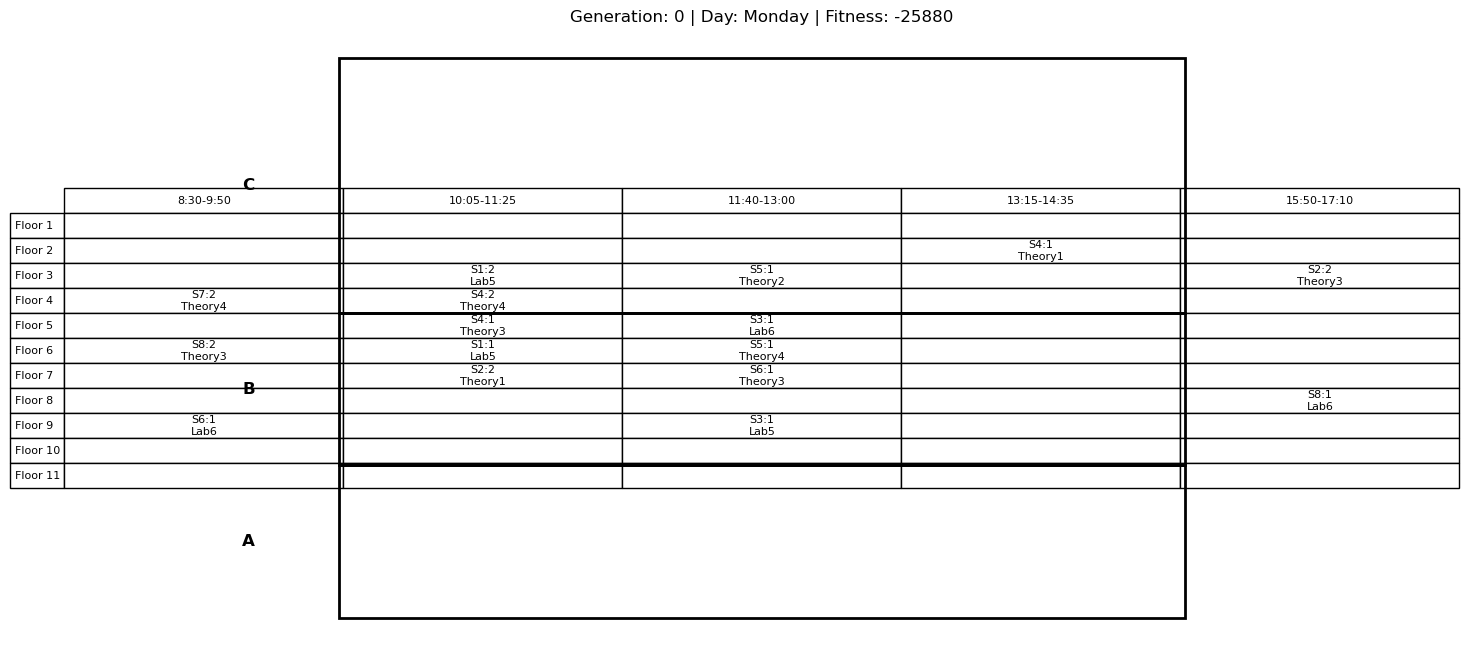

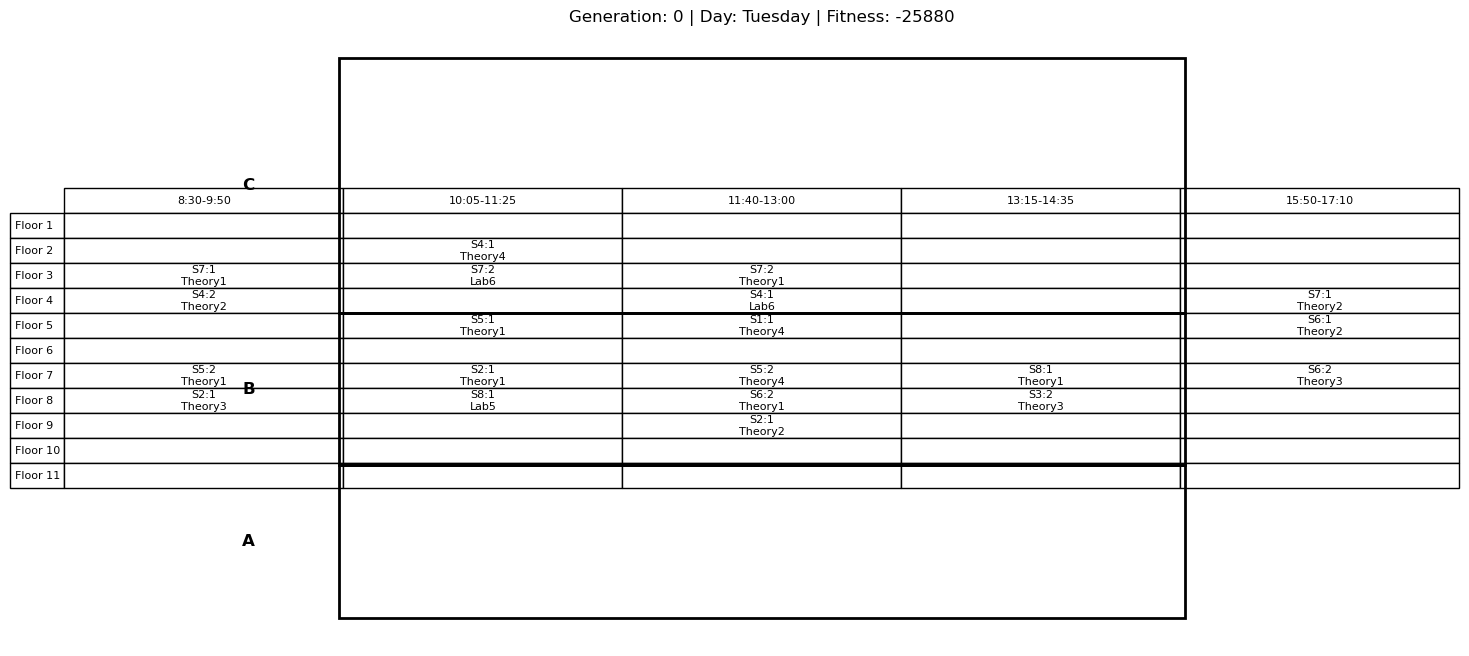

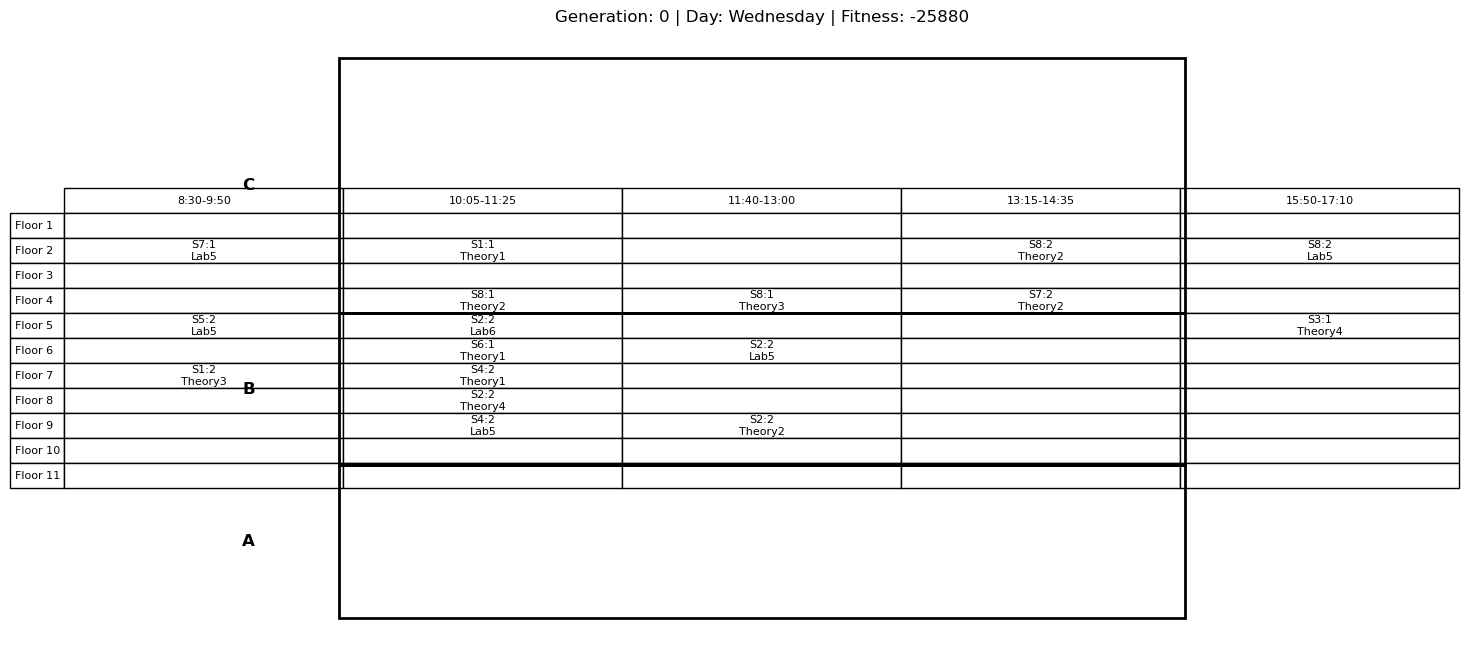

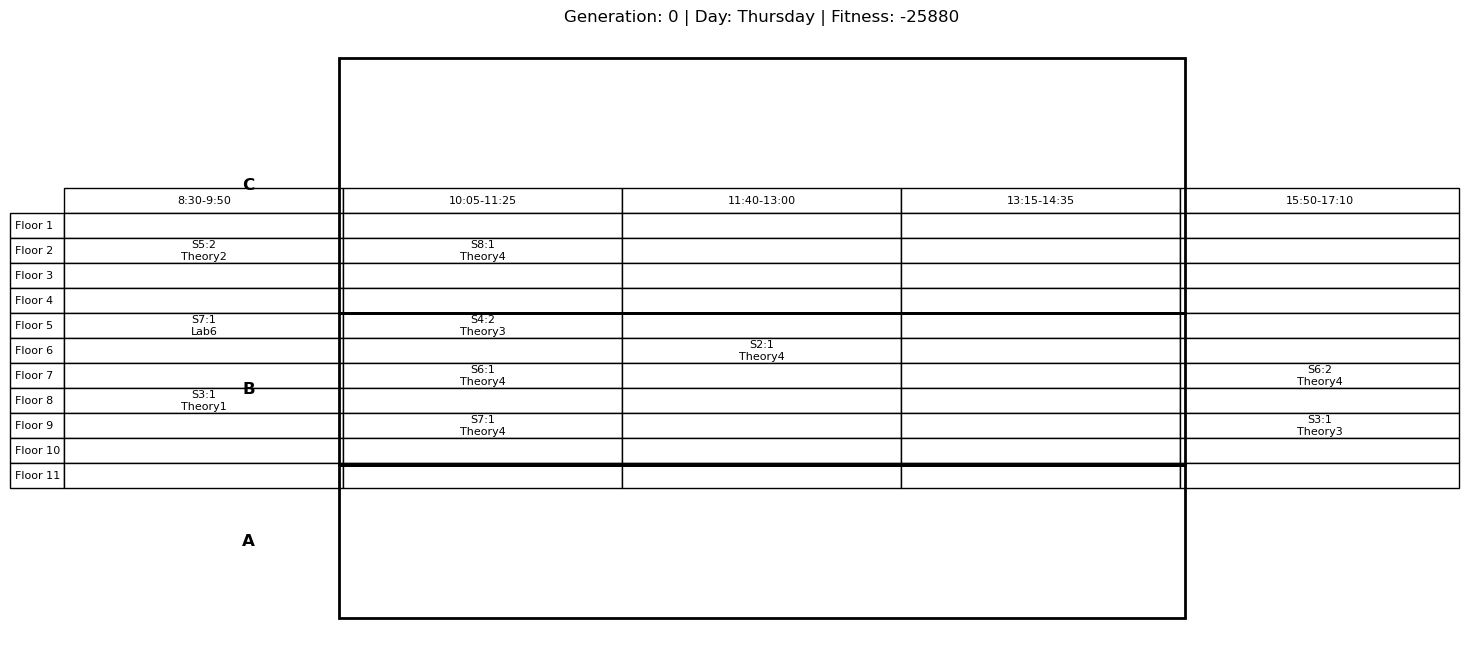

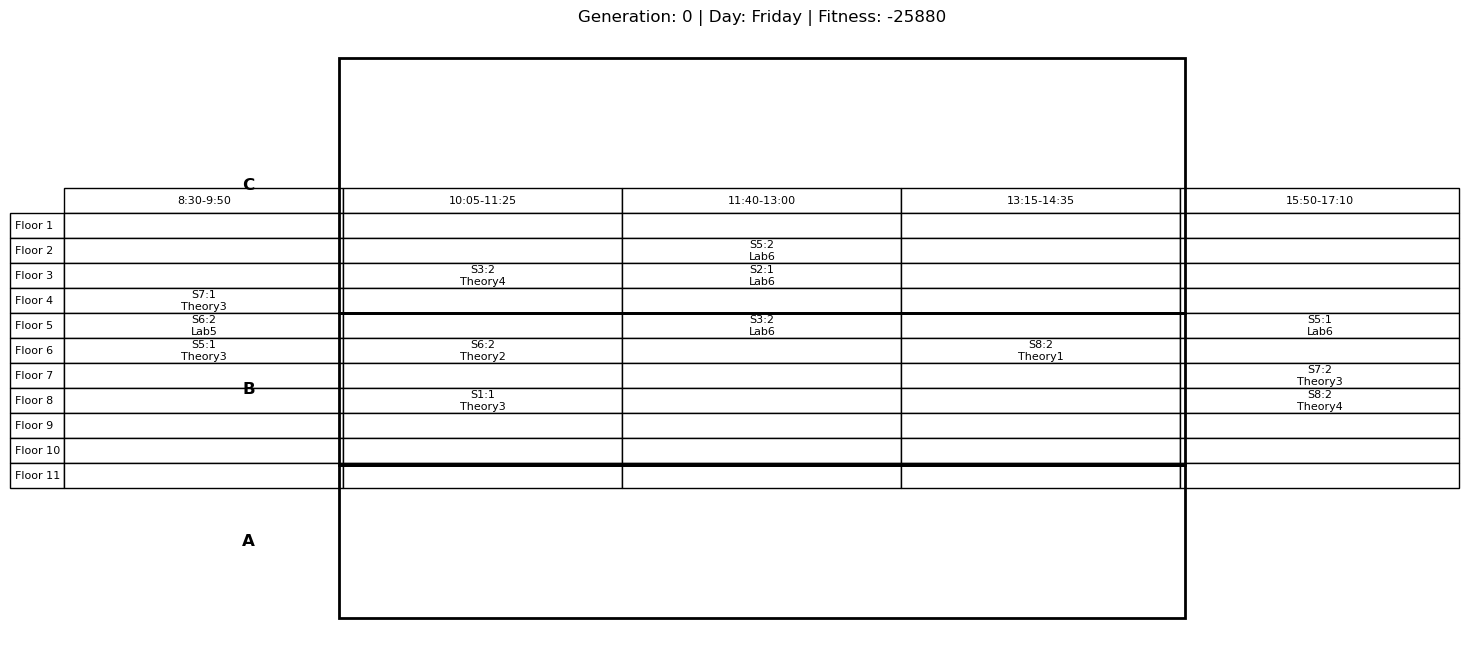

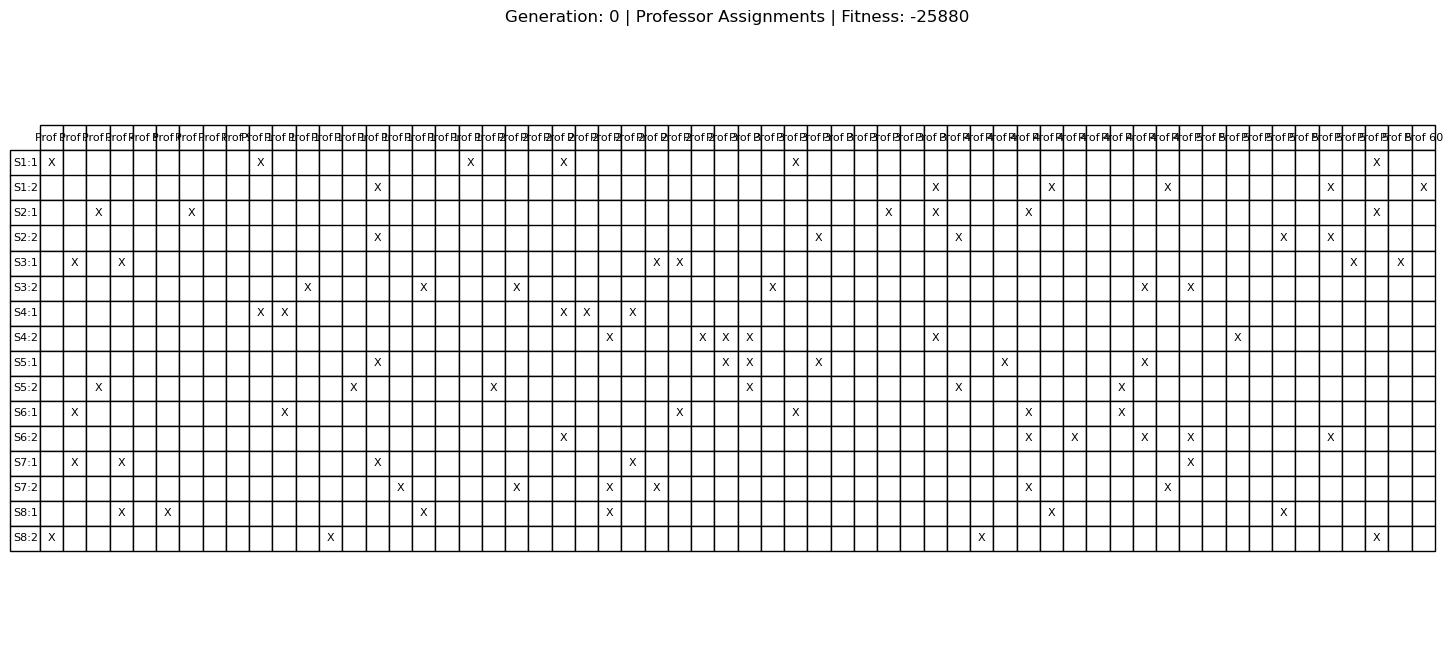

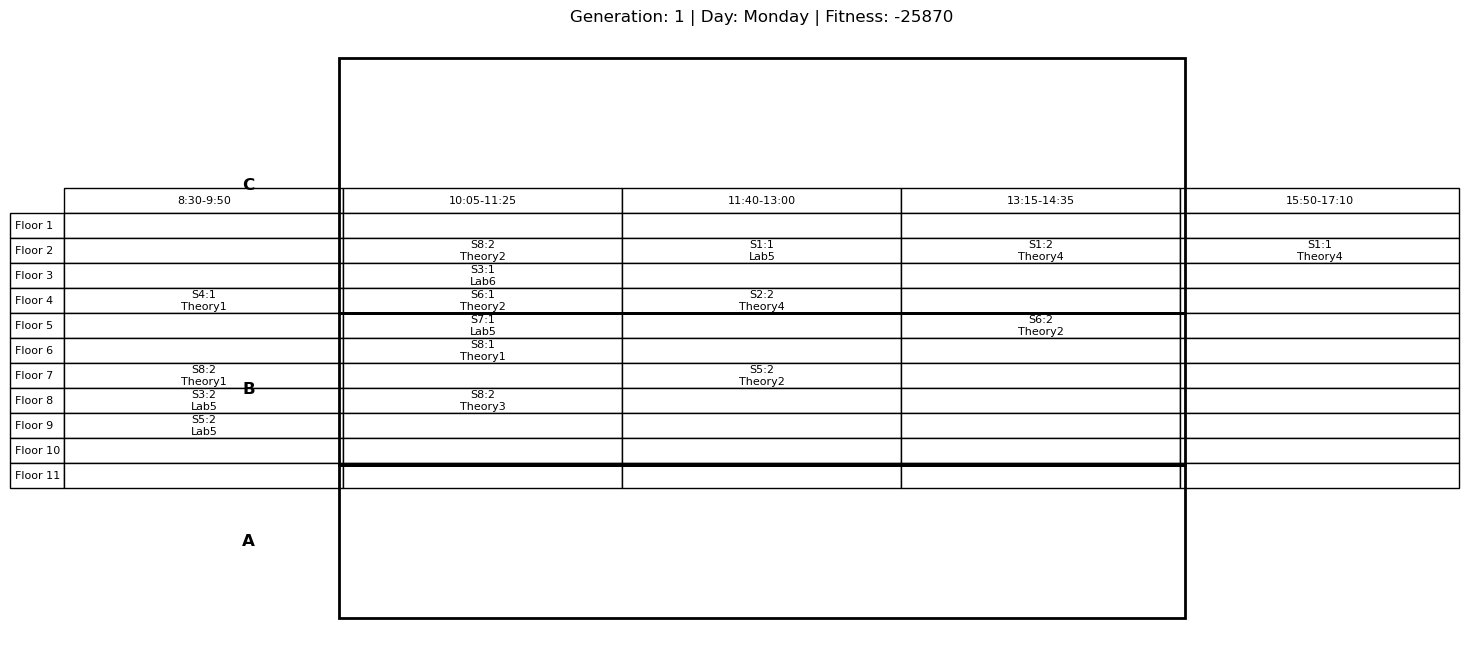

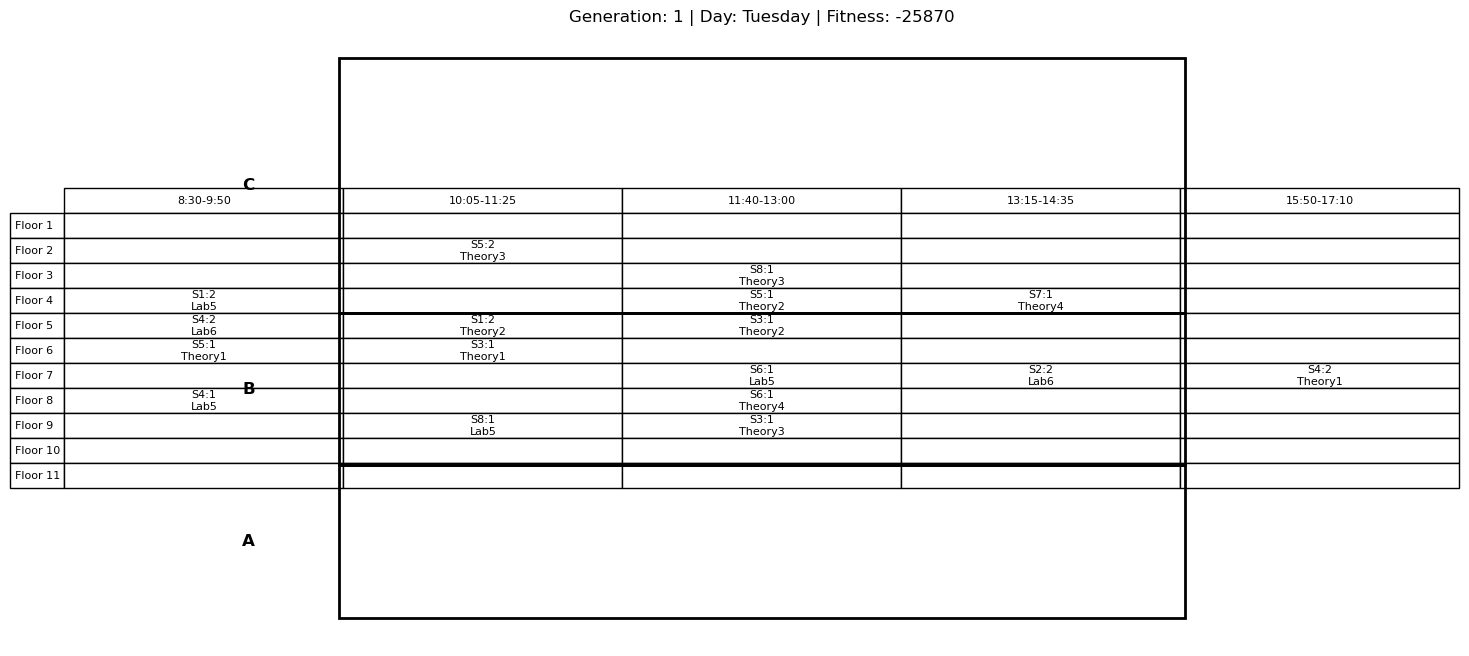

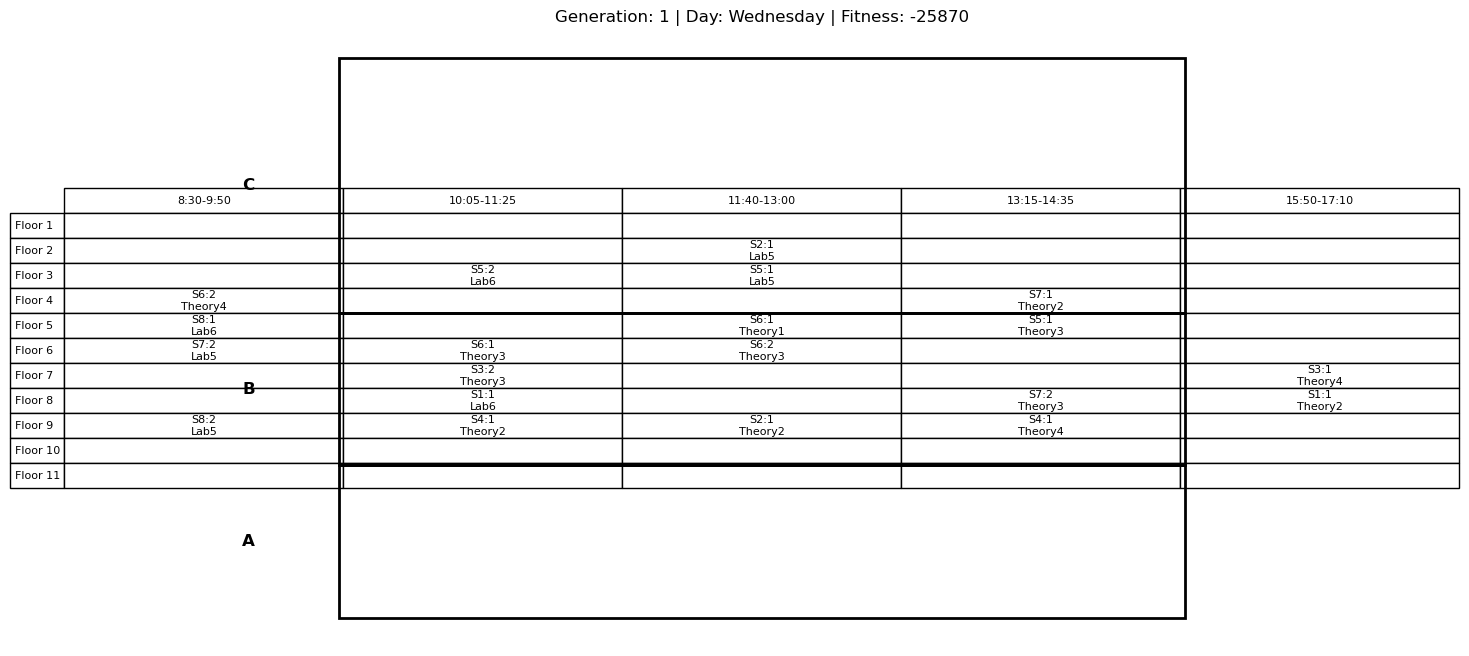

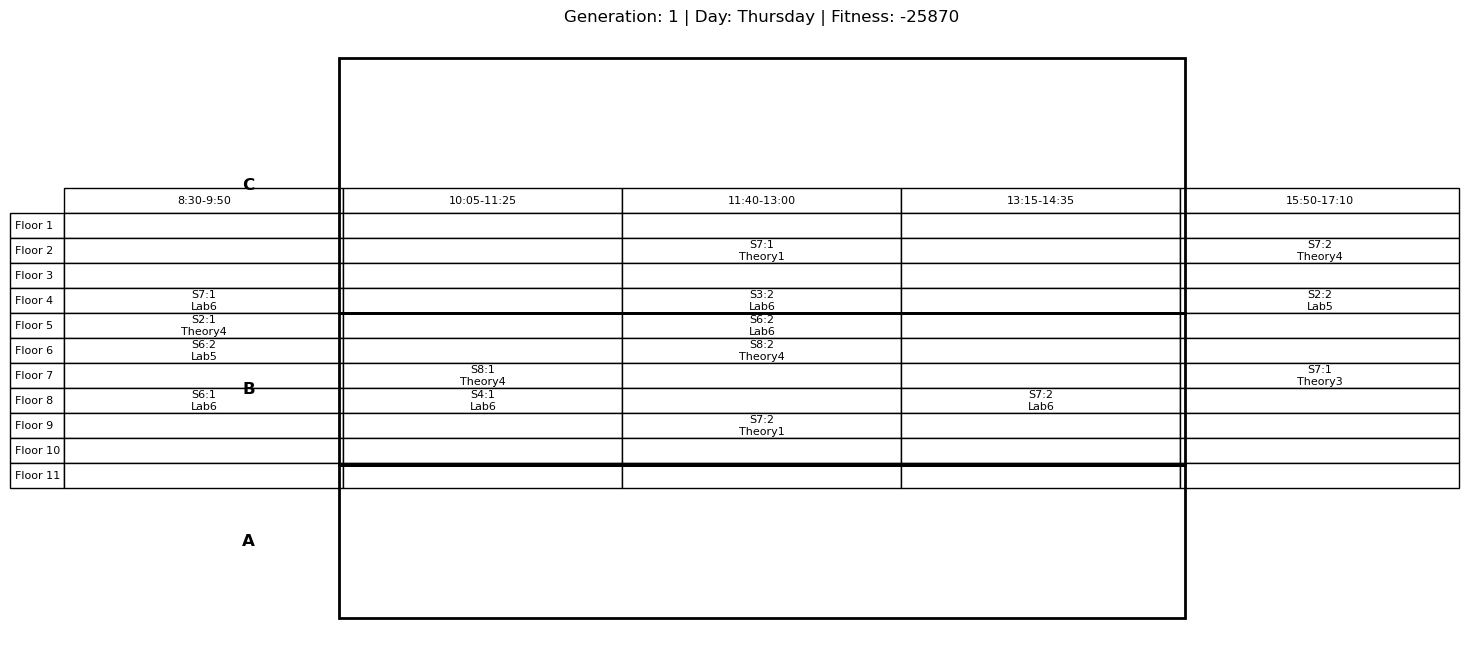

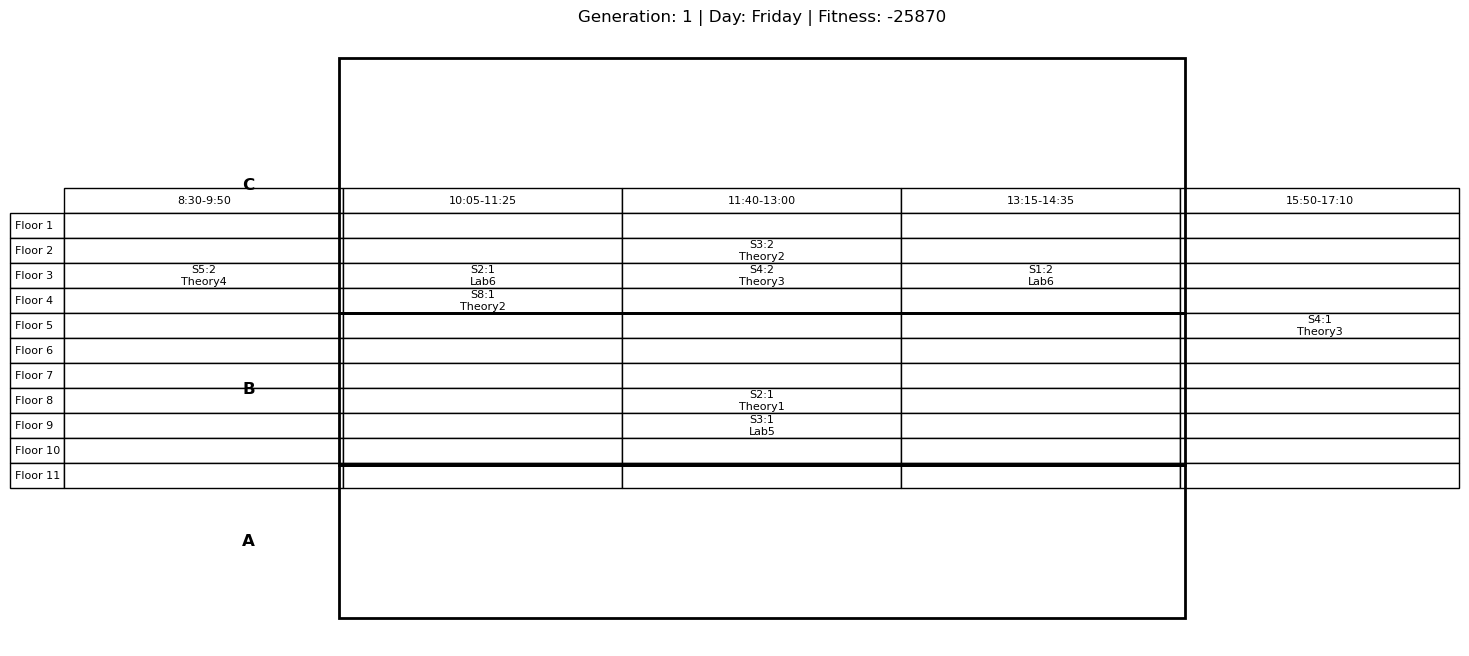

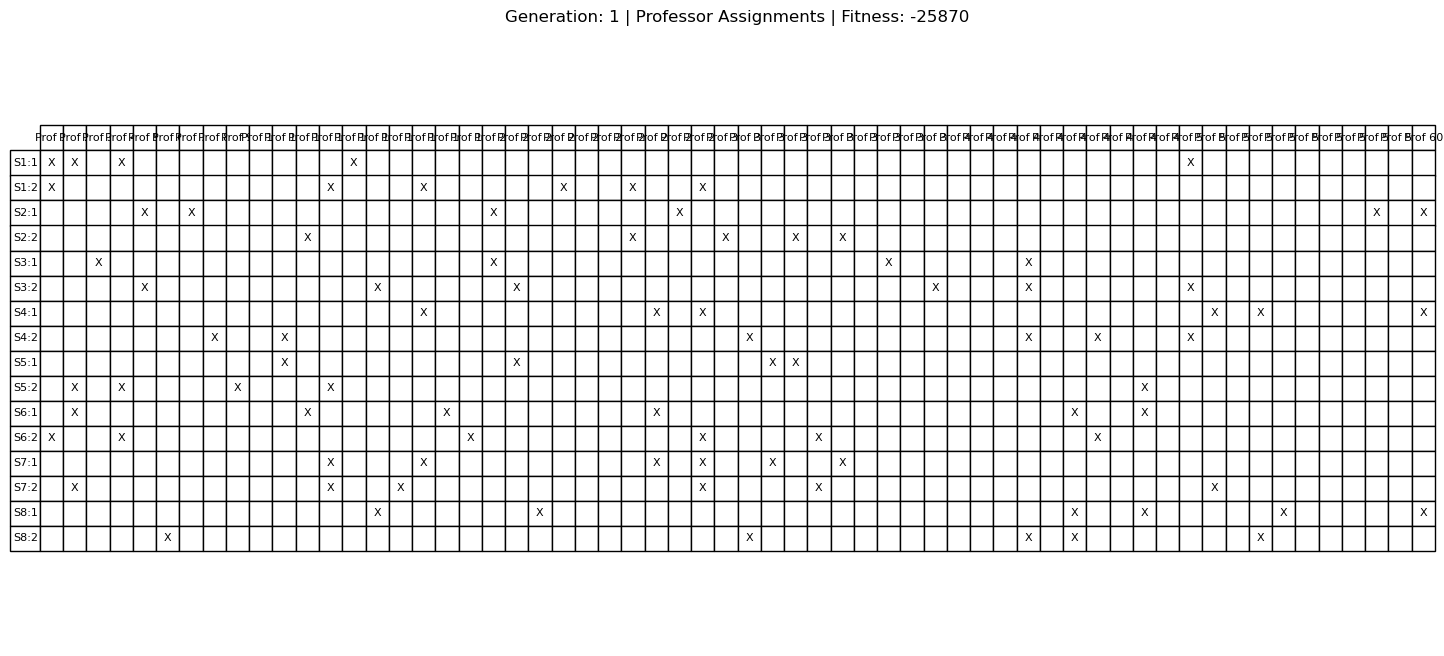

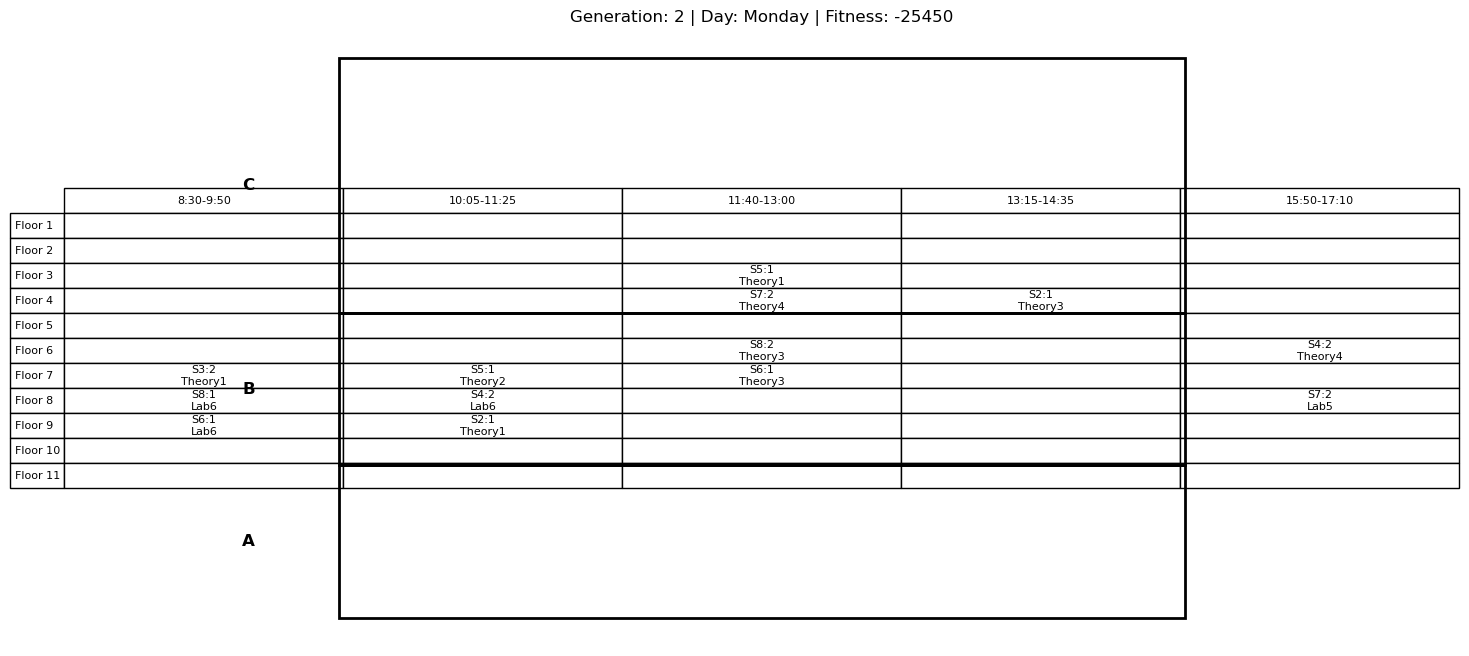

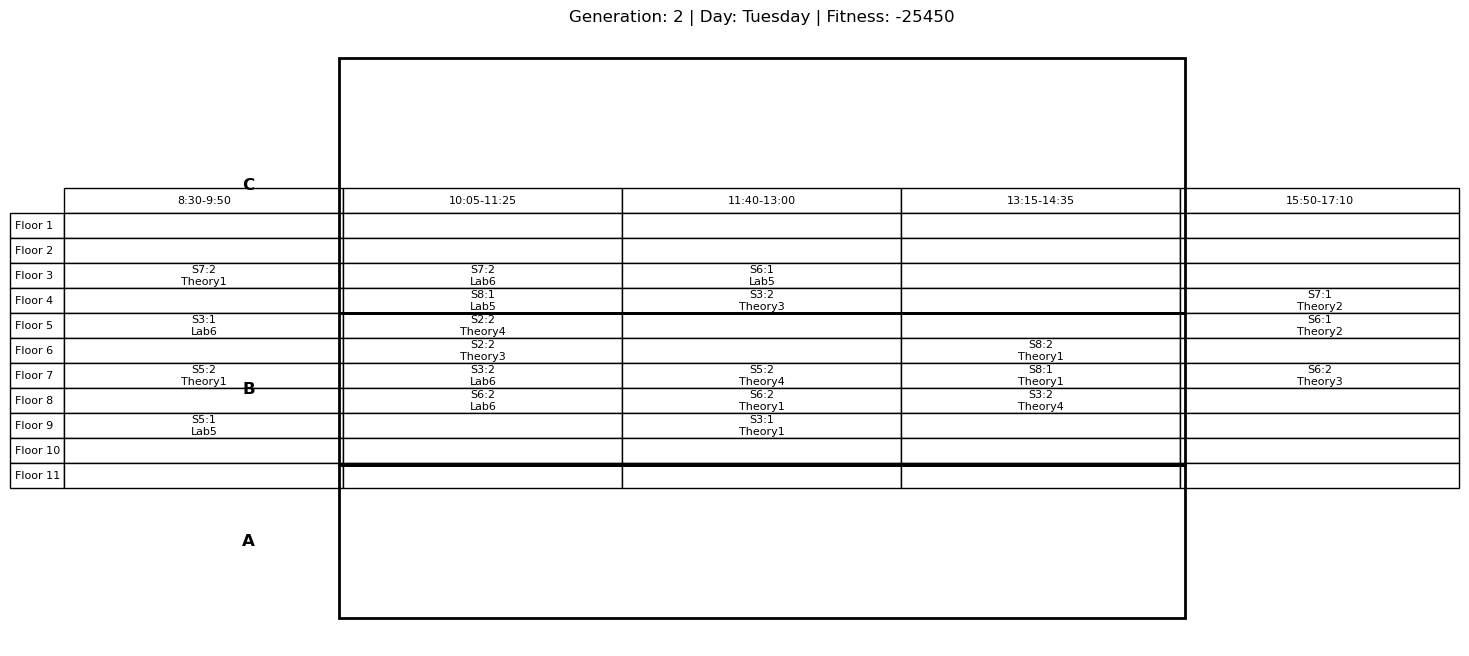

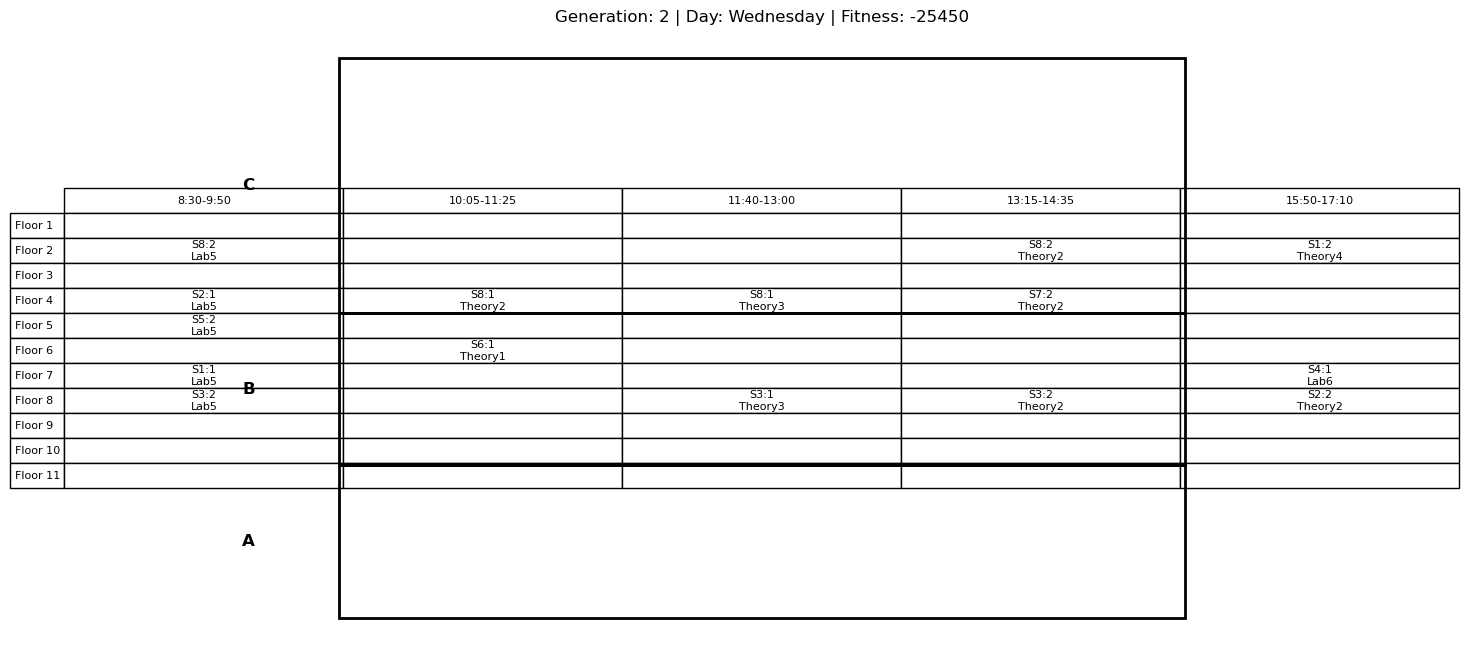

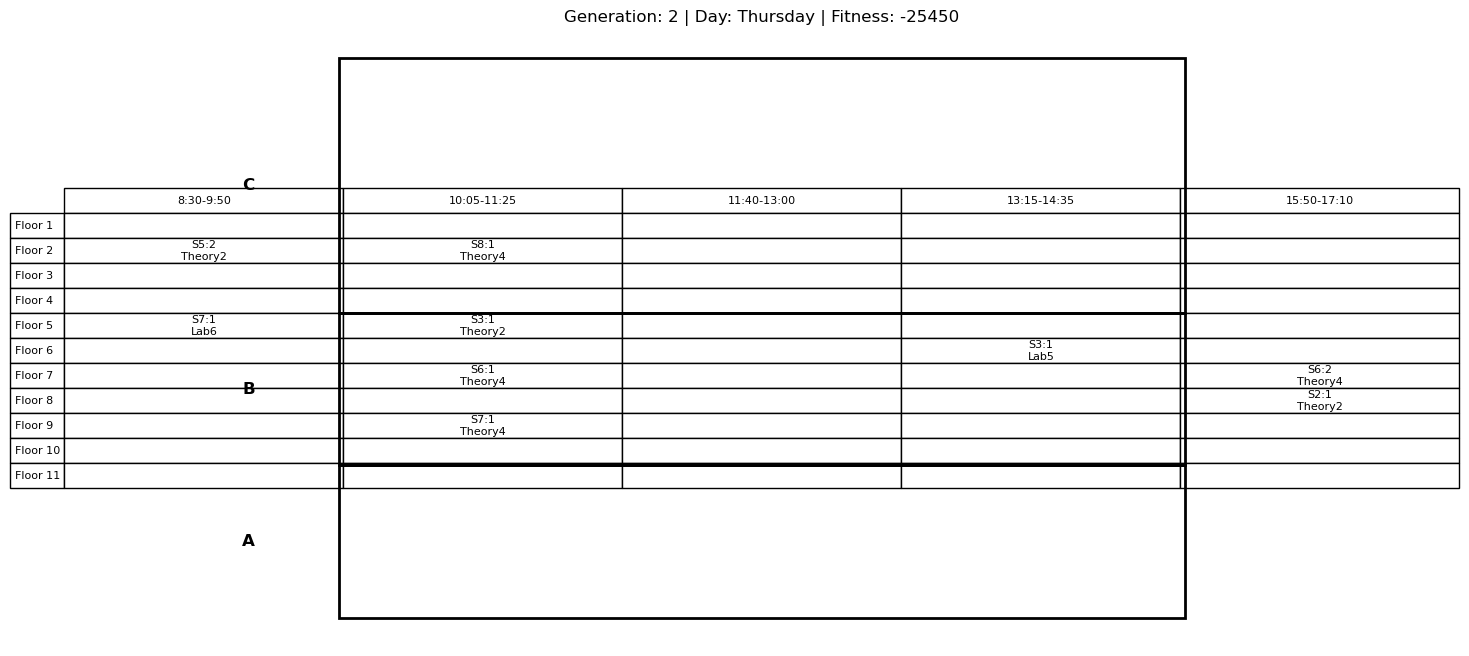

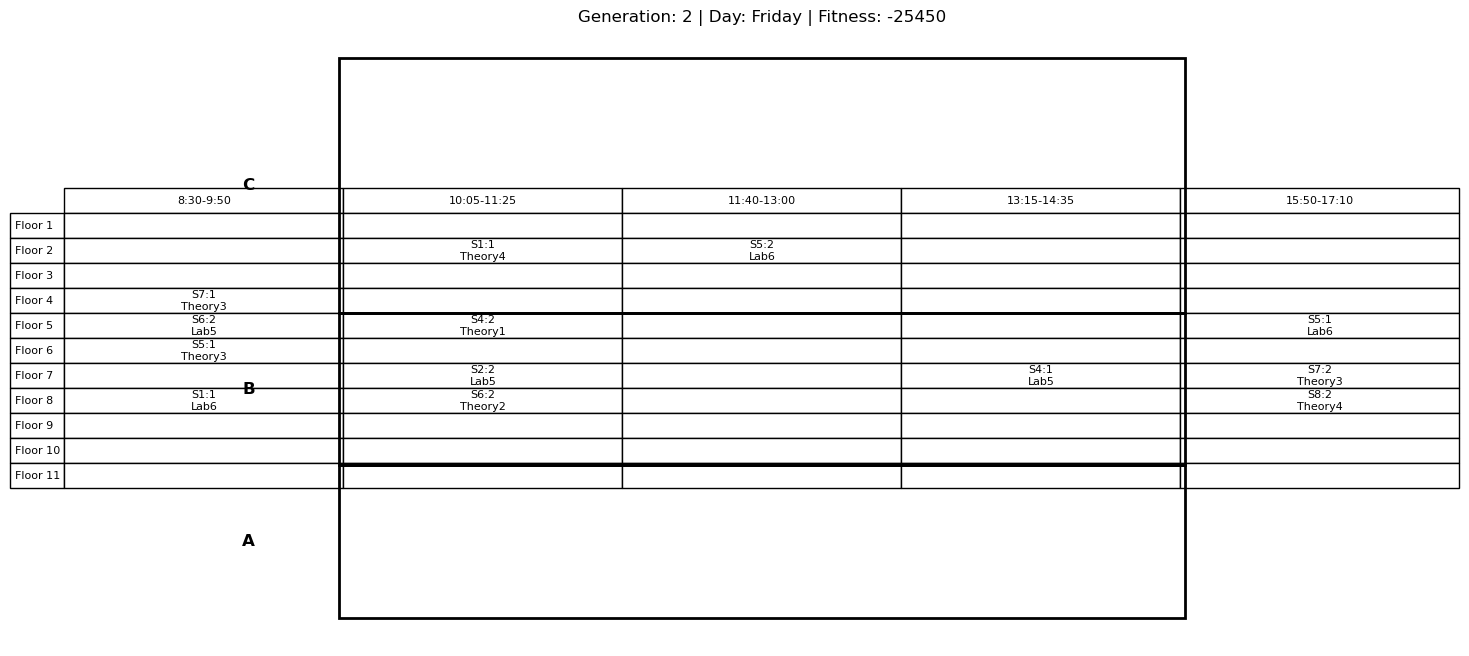

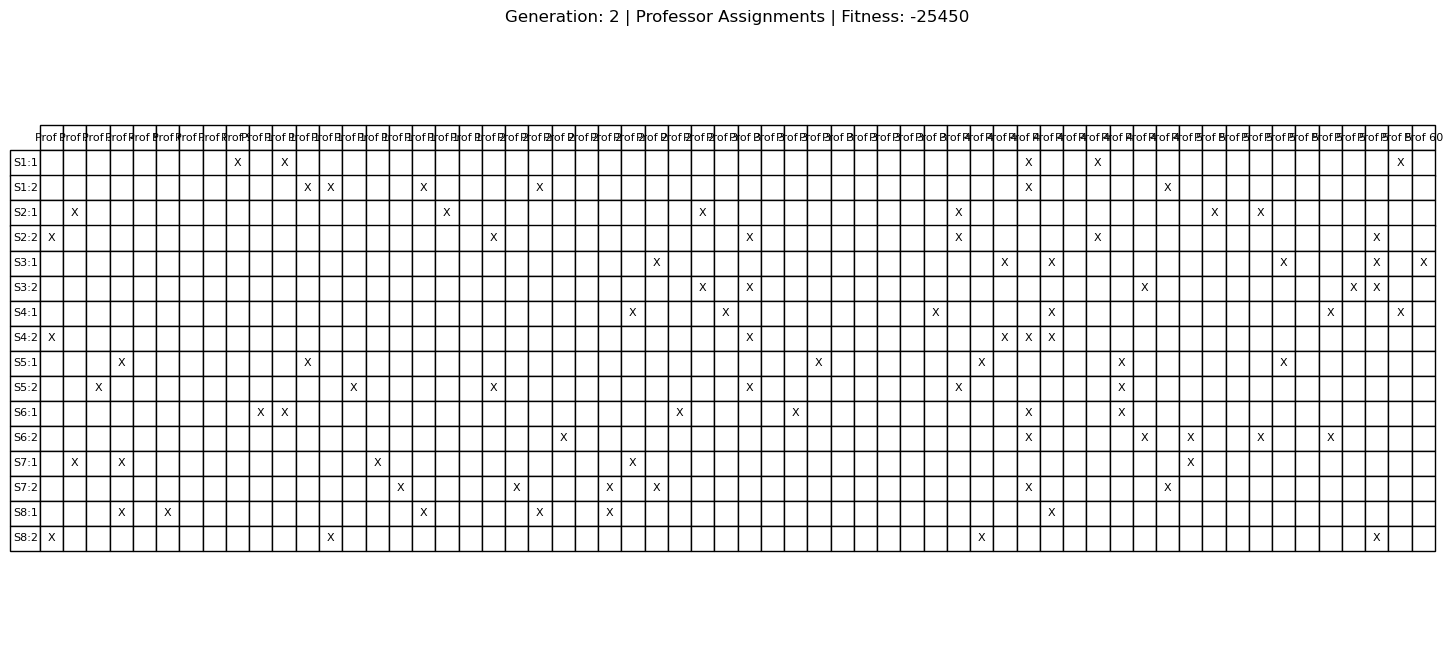

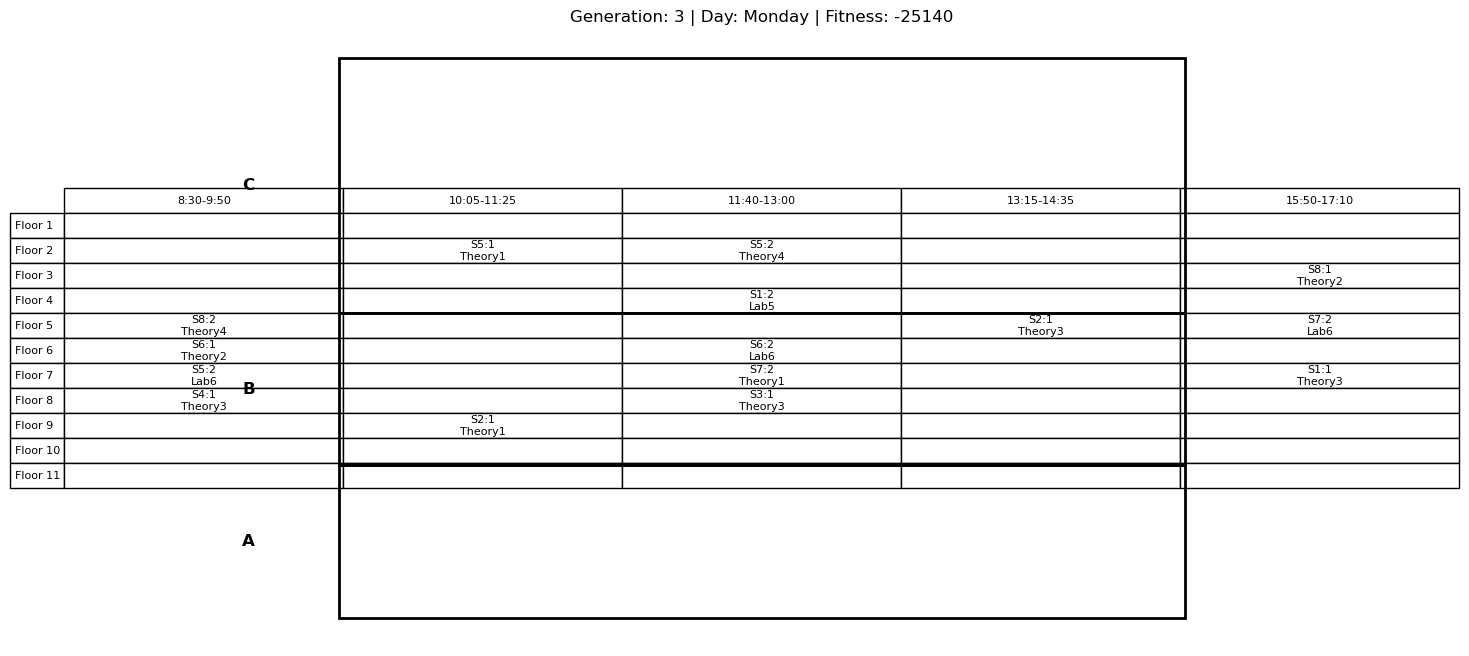

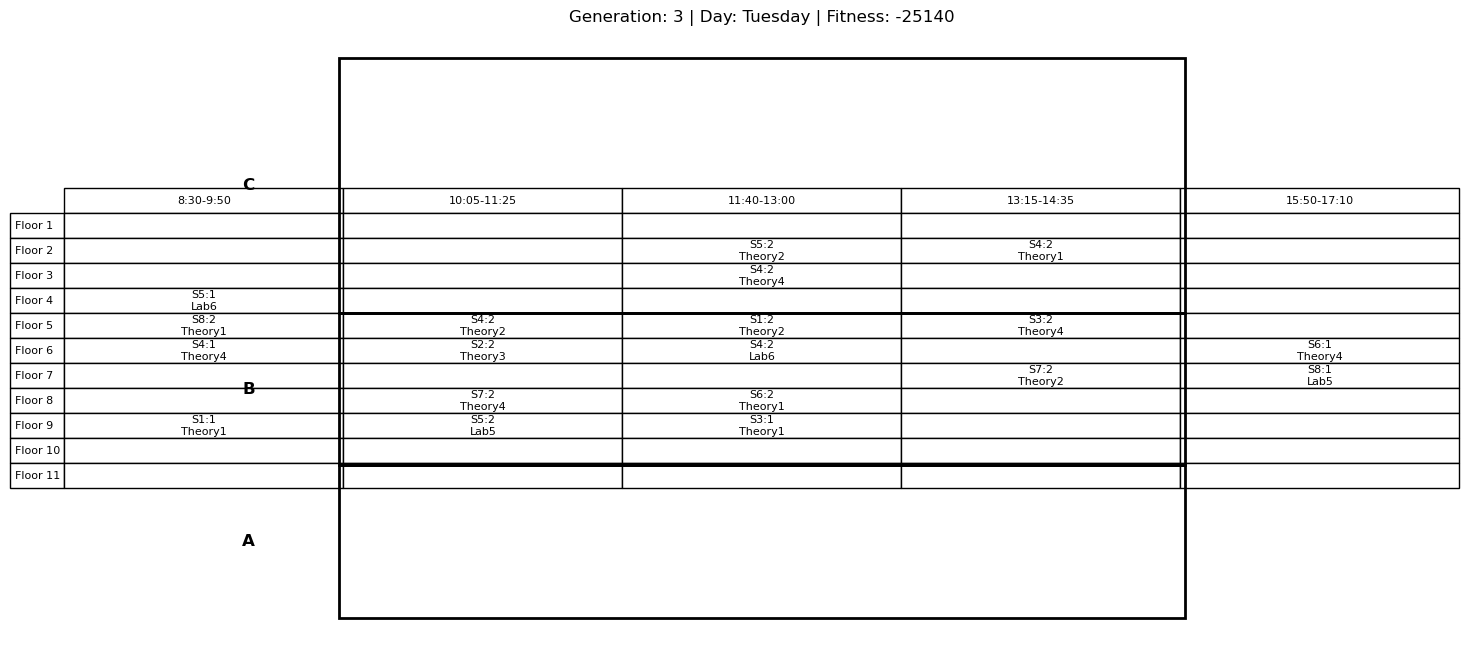

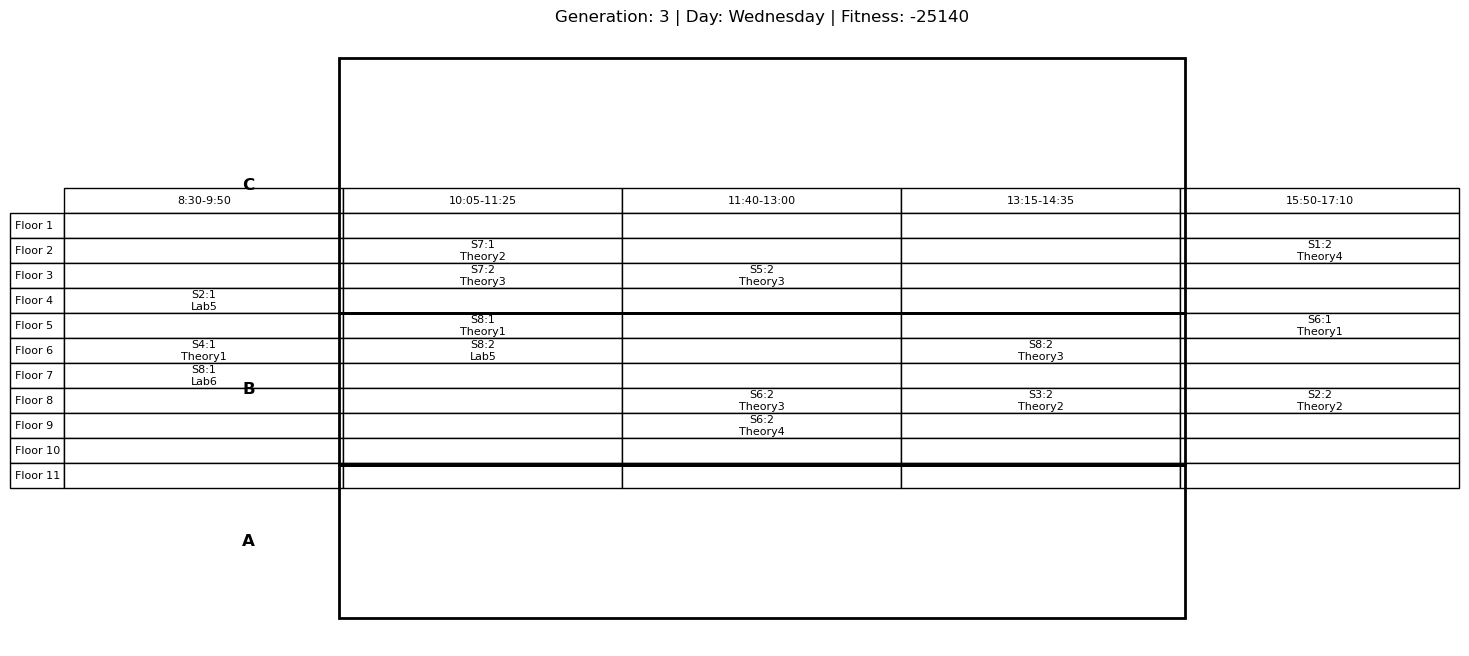

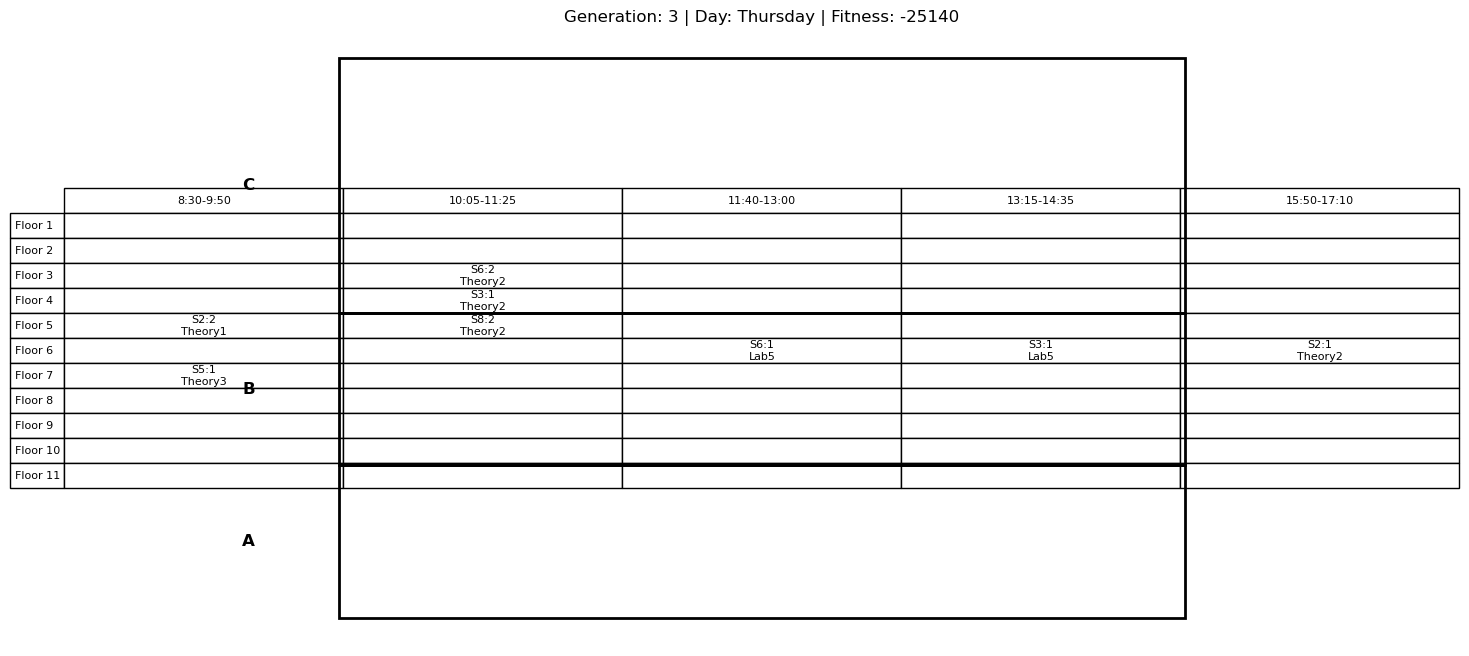

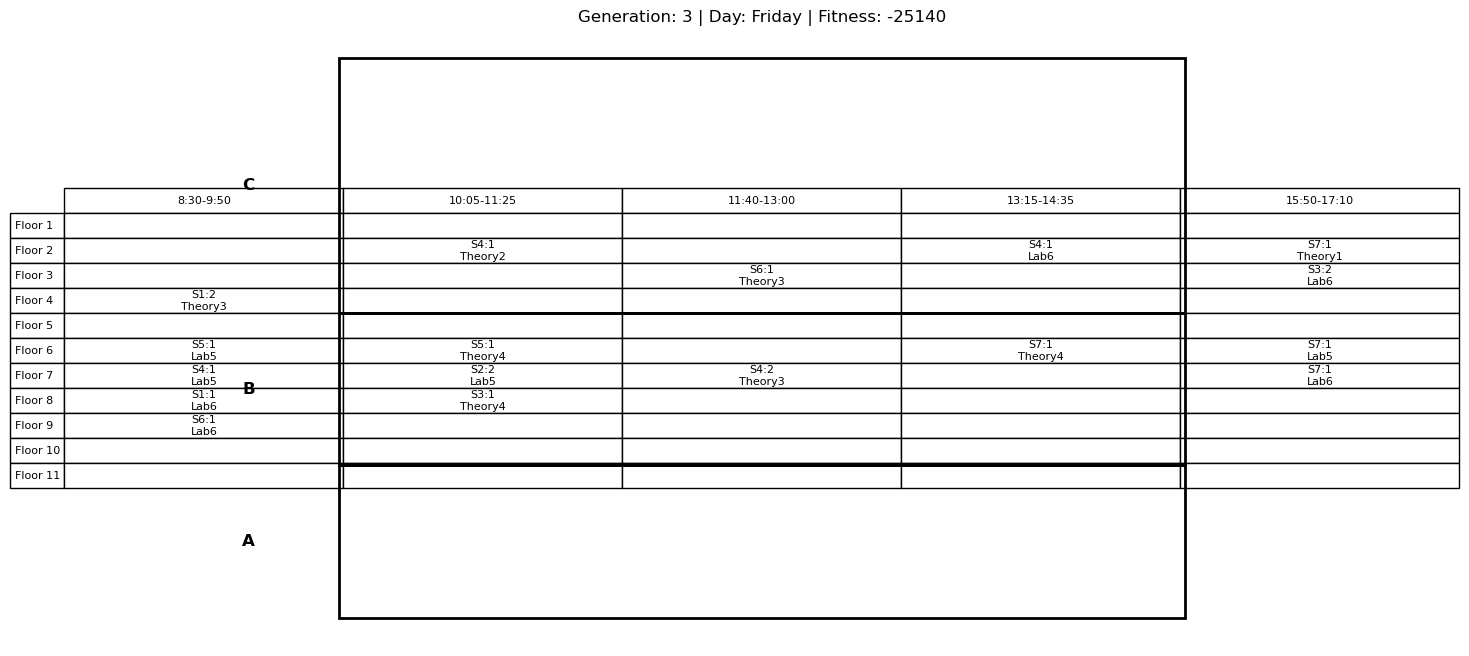

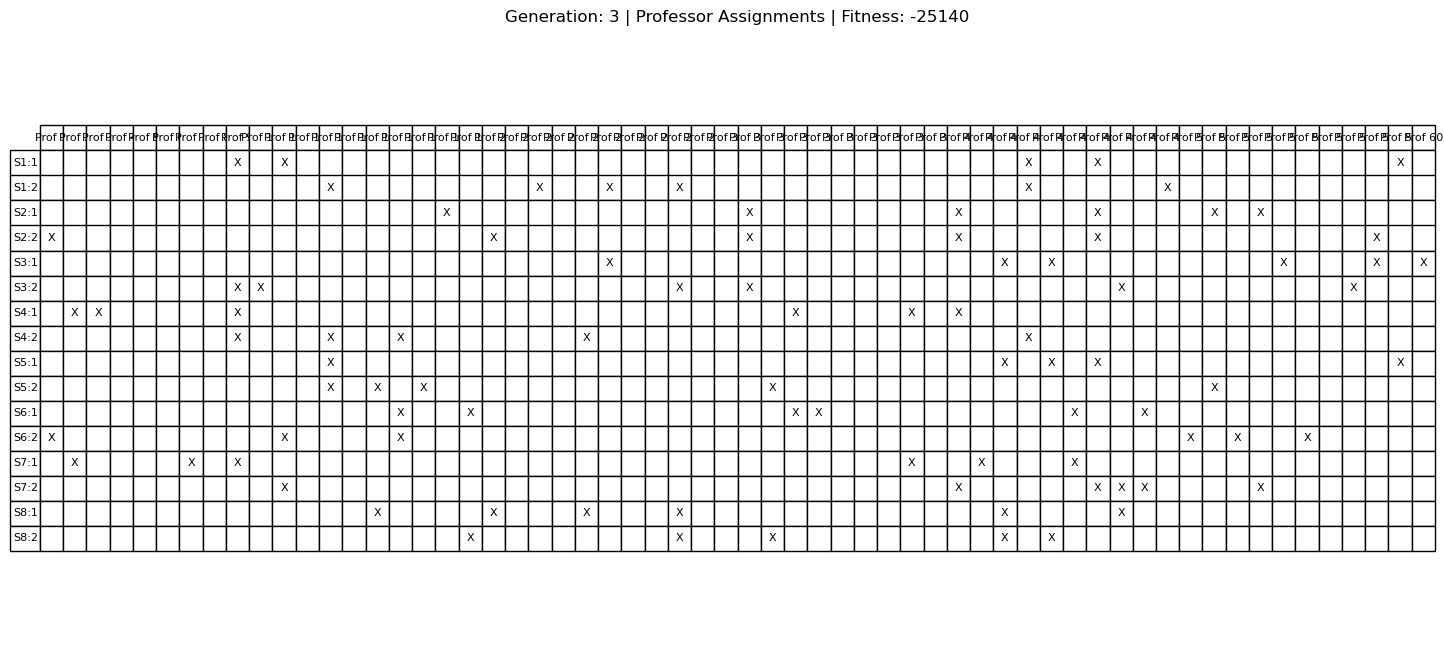

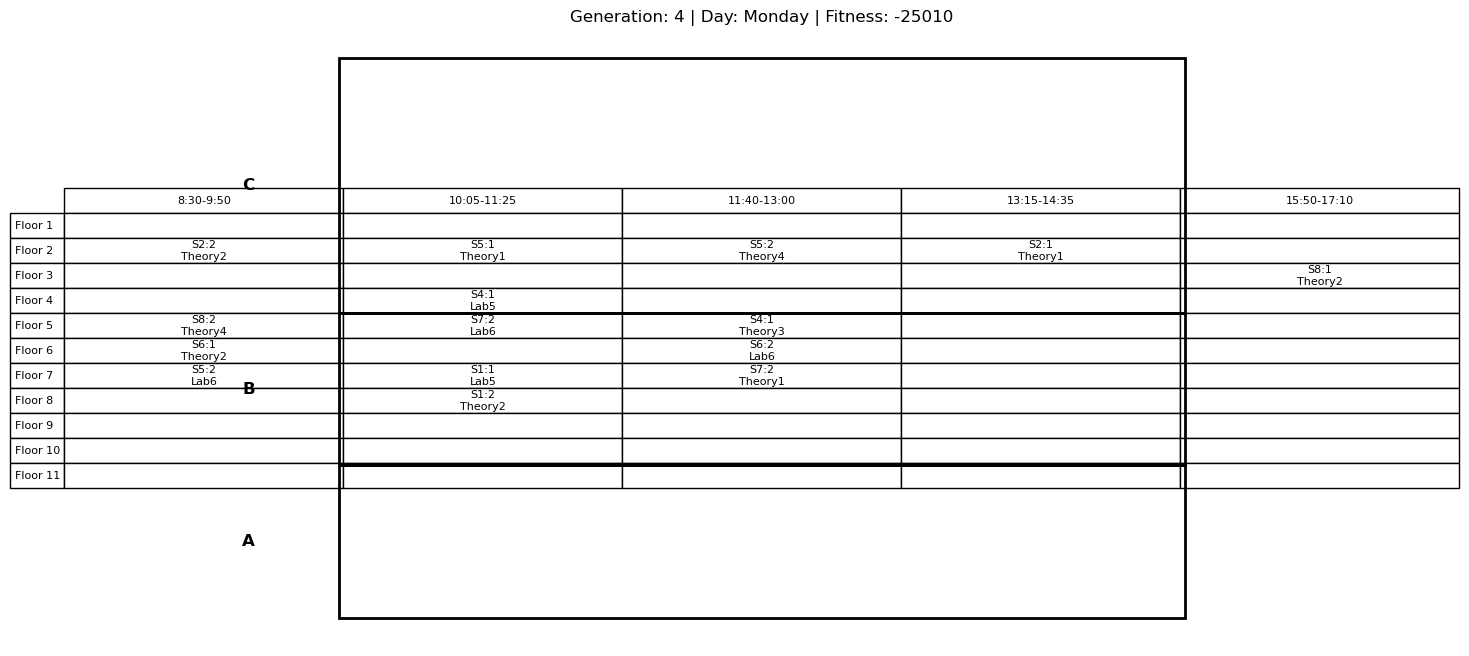

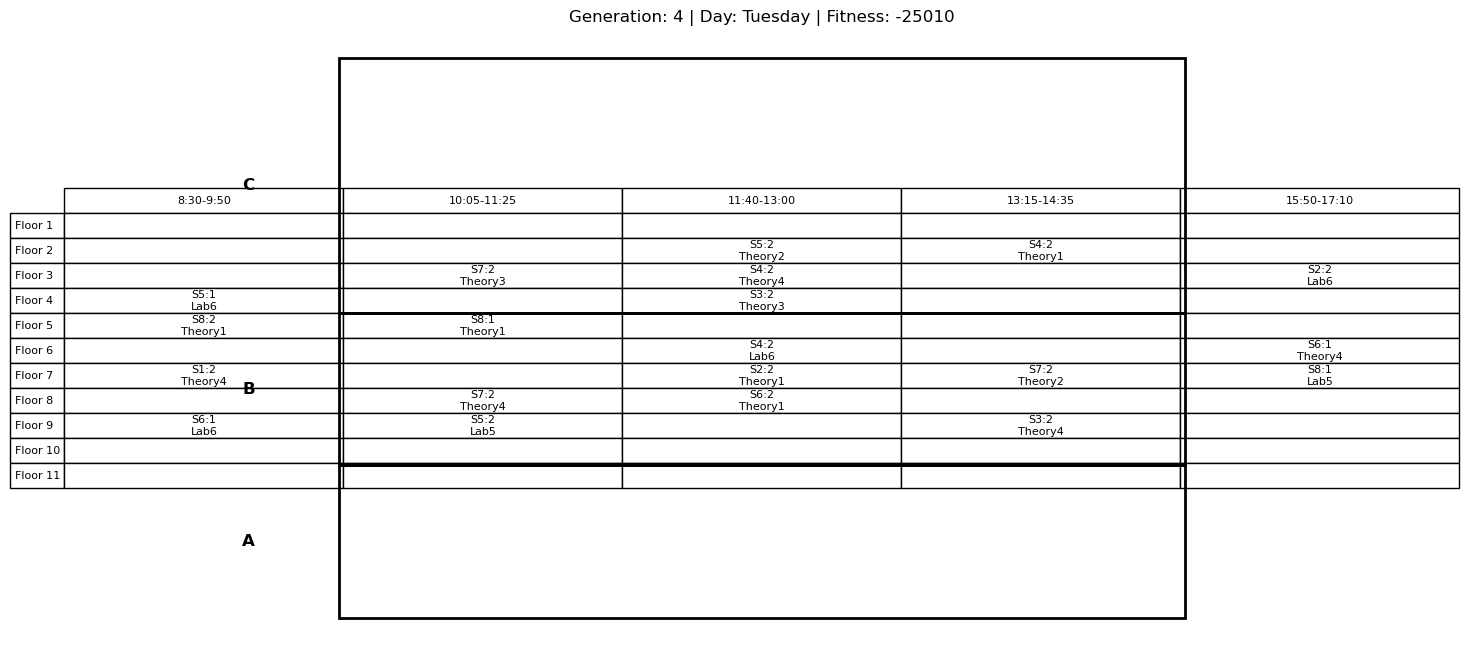

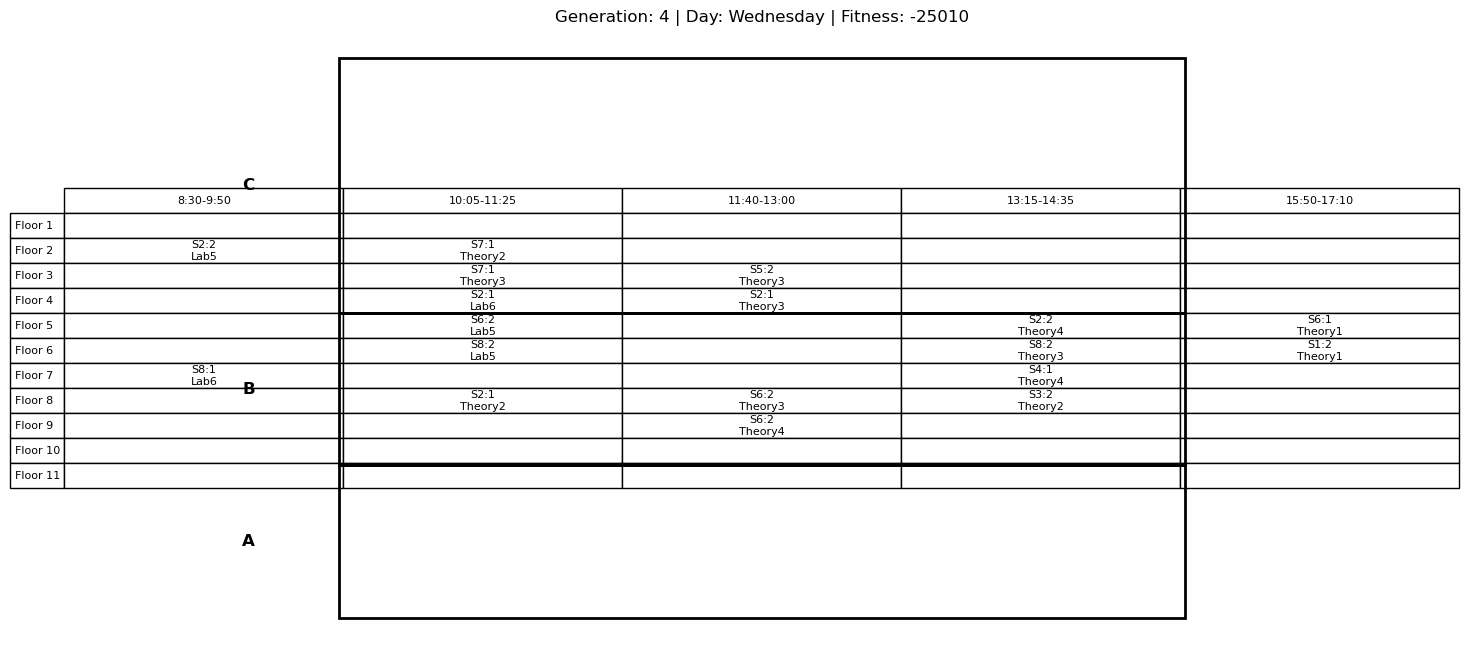

In [ ]:
def genetic_algorithm(population_size, num_generations):
    population = initialize_population(population_size)
    fitness_values = [sys.maxsize] * population_size

    for generation in range(num_generations):
        for i in range(population_size):
            timetable, section_strength = decode_chromosome(population[i])  # Unpack both values
            fitness_values[i] = evaluate_fitness(population[i], timetable, section_strength)  # Pass section_strength

        best_index = np.argmax(fitness_values)
        best_fitness = fitness_values[best_index]
        best_chromosome = population[best_index]

        #save_path = r"C:\Users\Crown Tech\Downloads"  # Your desired save path
        visualize_timetable(population, fitness_values, generation)

        if best_fitness == 0:
            print(f"Optimal solution found in generation {generation}!")
            timetable = decode_chromosome(best_chromosome)
            print("Timetable:")
            for entry in timetable:
                print(entry)
            break

        parent_indices = selection(fitness_values, num_parents=population_size // 2)
        parents = [population[i] for i in parent_indices]
        offspring = crossover_and_mutate(parents)
        population = parents + offspring

    else:
        print("Maximum number of generations reached without finding an optimal solution.")

if __name__ == "__main__":
    genetic_algorithm(population_size=100, num_generations=MAX_ITERATIONS)